In [1]:
import datetime 
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Load Data

In [2]:
base_path = './data_store'
df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_large.csv')

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### israel language translated to number

In [3]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [4]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [5]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [6]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [7]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

### crop outlier

In [8]:
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

### dataframe to model input and label

In [9]:
raw_datas = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication', 'corona_result']].values

In [10]:
input_datas = raw_datas[:, :-1]
gt_datas = raw_datas[:, -1]

### split train, validation, test datasets

In [11]:
def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size:]
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
#     test_data = data[:test_indices]
#     train_data = data[train_indices:]
    
    return train_data, test_data

In [12]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

In [13]:
not_test_datas, test_datas = split_train_test(raw_datas, test_ratio=0.2)
train_datas, valid_datas = split_train_test(not_test_datas, test_ratio=0.2)

train_input, train_gt = split_input_gt(train_datas)
valid_input, valid_gt = split_input_gt(valid_datas)
test_input, test_gt = split_input_gt(test_datas)

In [14]:
print(train_input.shape, train_gt.shape, valid_input.shape, valid_gt.shape, test_input.shape, test_gt.shape)

(3489815, 8) (3489815,) (872453, 8) (872453,) (1090567, 8) (1090567,)


### save model data

In [15]:
np.save(f'{base_path}/train_input', train_input)
np.save(f'{base_path}/train_gt', train_gt)
np.save(f'{base_path}/valid_input', valid_input)
np.save(f'{base_path}/valid_gt', valid_gt)
np.save(f'{base_path}/test_input', test_input)
np.save(f'{base_path}/test_gt', test_gt)

### load model data

In [16]:
loaded_train_input = np.load(f'{base_path}/train_input.npy')
loaded_train_gt = np.load(f'{base_path}/train_gt.npy')
loaded_valid_input = np.load(f'{base_path}/valid_input.npy')
loaded_valid_gt = np.load(f'{base_path}/valid_gt.npy')
loaded_test_input = np.load(f'{base_path}/test_input.npy')
loaded_test_gt = np.load(f'{base_path}/test_gt.npy')

### model training

In [17]:
logistic_clf = LogisticRegression(C=1000.0, random_state=0)
logistic_clf = logistic_clf.fit(loaded_train_input, loaded_train_gt)

### save model param 

In [18]:
joblib.dump(logistic_clf, f'{base_path}/logistic_israel.pkl') 

['./data_store/logistic_israel.pkl']

### model performance check with validation data

In [19]:
def display_performance(clf, pred, valid_input, valid_gt):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    plot_roc_curve(clf, valid_input, valid_gt)

In [20]:
loaded_logistic_clf = joblib.load('logistic_israel.pkl') 

accuracy 0.8782
precision 0.2240
recall 0.4901
f1-score 0.3075
[[742649  81690]
 [ 24533  23581]]


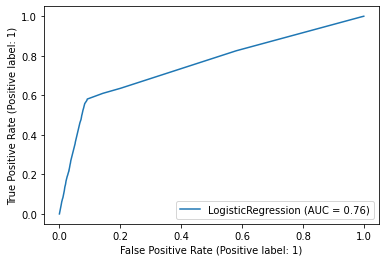

In [21]:
pred = loaded_logistic_clf.predict(valid_input)
display_performance(loaded_logistic_clf, pred, valid_input, valid_gt)